In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
print(os.listdir("/content/drive/MyDrive/Digit Recognizer"))

['sample_submission.csv', 'test.csv', 'train.csv']


# **Loading Dataset**

In [2]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# **Preparing The Dataset**

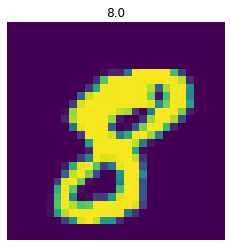

In [12]:
# Prepare Dataset
# load data
train = pd.read_csv(r"/content/drive/MyDrive/Digit Recognizer/train.csv",dtype = np.float32)
test = pd.read_csv(r"/content/drive/MyDrive/Digit Recognizer/test.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

# **Defining Recurrent Neural Network Model**

In [13]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
a=  torch.randn(12,3)
print(a)
torch.max(a, 1)

tensor([[ 2.4165,  0.7829,  0.8853],
        [-1.8049,  0.1676,  0.0890],
        [-0.5254,  0.7805, -0.2197],
        [ 2.4775,  0.8164,  1.4448],
        [ 0.4699,  0.2846,  1.1243],
        [-0.3442,  0.5169, -1.0861],
        [-0.2327,  0.0545,  0.2461],
        [-0.1673, -0.5686, -0.6393],
        [ 0.7629,  1.9513, -0.6477],
        [-1.5569, -0.4966, -1.1447],
        [ 0.9450,  0.5484, -0.0715],
        [ 0.6697, -0.6312, -0.8992]])


torch.return_types.max(values=tensor([ 2.4165,  0.1676,  0.7805,  2.4775,  1.1243,  0.5169,  0.2461, -0.1673,
         1.9513, -0.4966,  0.9450,  0.6697]), indices=tensor([0, 1, 1, 0, 2, 1, 2, 0, 1, 1, 0, 0]))

# **Calculating Losses and Accuracy**

In [29]:
seq_dim = 28
loss_list= []
iteration_list = []
accuracy_list = []

count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(train)
        
        loss = error(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0 :
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                outputs = model(images)
                
                predicted = torch.max(outputs.data, 1)[1]
                total += labels.size(0)
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            if count % 500 == 0:
                print('iterations: {}, loss = {}, accuracy = {} %'.format(count, loss, accuracy))

iterations: 500, loss = 0.13492824137210846, accuracy = 94.46428680419922 %
iterations: 1000, loss = 0.13234876096248627, accuracy = 94.57142639160156 %
iterations: 1500, loss = 0.0735597088932991, accuracy = 94.16666412353516 %
iterations: 2000, loss = 0.2095690369606018, accuracy = 95.85713958740234 %
iterations: 2500, loss = 0.1303889900445938, accuracy = 94.38095092773438 %
iterations: 3000, loss = 0.048413749784231186, accuracy = 95.9047622680664 %
iterations: 3500, loss = 0.3354620635509491, accuracy = 95.55952453613281 %
iterations: 4000, loss = 0.16179077327251434, accuracy = 91.47618865966797 %
iterations: 4500, loss = 0.34604838490486145, accuracy = 94.54762268066406 %
iterations: 5000, loss = 0.12153680622577667, accuracy = 94.92857360839844 %
iterations: 5500, loss = 0.22813203930854797, accuracy = 94.97618865966797 %
iterations: 6000, loss = 0.16760045289993286, accuracy = 95.6547622680664 %
iterations: 6500, loss = 0.15025585889816284, accuracy = 95.51190185546875 %
itera

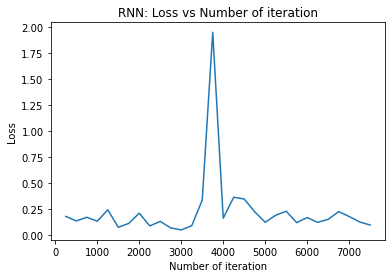

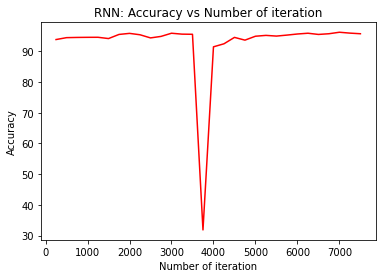

In [30]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()

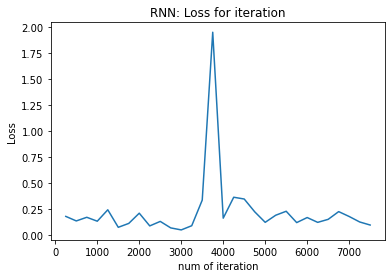

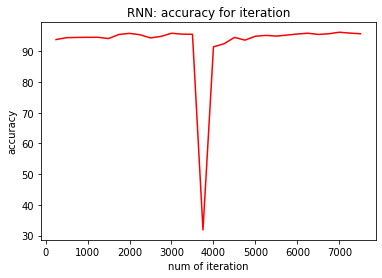

In [31]:
plt.plot(iteration_list, loss_list)
plt.xlabel('num of iteration')
plt.ylabel('Loss')
plt.title('RNN: Loss for iteration')
plt.show()

plt.plot(iteration_list, accuracy_list, color = 'red')
plt.xlabel('num of iteration')
plt.ylabel('accuracy')
plt.title("RNN: accuracy for iteration")
plt.savefig('graph.png')
plt.show()